In [1]:
import os

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [2]:
# constants
IMG_HEIGHT, IMG_WIDTH = 150, 150
STEPS_PER_EPOCH = 50
VALIDATION_STEPS = 20
EPOCHS = 50

DATA_PATH = os.path.join(os.getcwd(),'data')
couch_path = os.path.join(DATA_PATH, 'couch') # 2016 couch pictures 
chair_path = os.path.join(DATA_PATH, 'chair') # 8141 chair pictures

couch_pictures = os.listdir(couch_path)
chair_pictures = os.listdir(chair_path)

In [3]:
# train-validation-test split
from shutil import copy2

def split():
    couch_train, couch_val_test = train_test_split(couch_pictures, train_size=0.9, test_size=0.1)
    couch_val, couch_test = train_test_split(couch_val_test, train_size=0.5, test_size=0.5)# train:validation:test = 90:5:5
    
    # trainning data chair:couch = 1:1, val/test data chair:couch = 4:1
    chair_train, chair_val_test = train_test_split(chair_pictures, train_size=0.22, test_size=0.1) 
    chair_val, chair_test = train_test_split(chair_val_test, train_size=0.5, test_size=0.5)
    
    if not os.path.exists('train'):
        os.mkdir('train')
        os.mkdir('train/couch')
        os.mkdir('train/chair')
        for filename in couch_train:
            copy2(os.path.join(couch_path, filename), 'train/couch')
        for filename in chair_train:
            copy2(os.path.join(chair_path, filename), 'train/chair')
    
    if not os.path.exists('val'):
        os.mkdir('val')
        os.mkdir('val/couch')
        os.mkdir('val/chair')
        for filename in couch_val:
            copy2(os.path.join(couch_path, filename), 'val/couch')
        for filename in chair_val:
            copy2(os.path.join(chair_path, filename), 'val/chair')
    
    if not os.path.exists('test'):
        os.mkdir('test')
        os.mkdir('test/couch')
        os.mkdir('test/chair')
        for filename in couch_test:
            copy2(os.path.join(couch_path, filename), 'test/couch')
        for filename in chair_test:
            copy2(os.path.join(chair_path, filename), 'test/chair')

if not (os.path.exists('train') or os.path.exists('val') or os.path.exists('test')):
    split()
    
TRAIN_DATA = os.path.join(os.getcwd(),'train')
VAL_DATA = os.path.join(os.getcwd(),'val')
TEST_DATA = os.path.join(os.getcwd(),'test')

In [4]:
# data augmentation
train_chair_path = os.path.join(TRAIN_DATA, 'chair')
train_chairs = os.listdir(train_chair_path)
train_couch_path = os.path.join(TRAIN_DATA, 'couch')
train_couches = os.listdir(train_couch_path)

def augmentation():
    generator_factory = ImageDataGenerator(
        rotation_range=10, 
        width_shift_range=0.2,
        height_shift_range=0.2,            
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    for filename in train_chairs:
        img = load_img(os.path.join(train_chair_path, filename), target_size=(299, 299))
        img = np.expand_dims(img, axis=0) 
        img_generator = generator_factory.flow(img, batch_size=1, save_to_dir=train_chair_path, save_format='png')
        for _ in range(3):
            sampled_transformed_img = next(img_generator) 
            sampled_transformed_img = np.squeeze(sampled_transformed_img, axis=0) 
            
    for filename in train_couches:
        img = load_img(os.path.join(train_couch_path, filename), target_size=(299, 299))
        img = np.expand_dims(img, axis=0) 
        img_generator = generator_factory.flow(img, batch_size=1, save_to_dir=train_couch_path, save_format='png')
        for _ in range(3):
            sampled_transformed_img = next(img_generator) 
            sampled_transformed_img = np.squeeze(sampled_transformed_img, axis=0)

if len(train_chairs) < 5000 or len(train_couches) < 5000:
    augmentation()

In [5]:
# Set up generators of datasets

def setup_aug_generator(data_dir):
    generator_factory = ImageDataGenerator(rotation_range=10, 
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,            
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           fill_mode='nearest',
                                           preprocessing_function=preprocess_input)
    generator = generator_factory.flow_from_directory(data_dir, target_size=(IMG_HEIGHT, IMG_WIDTH))
    return generator
def setup_generator(data_dir):
    generator_factory = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = generator_factory.flow_from_directory(data_dir, target_size=(IMG_HEIGHT, IMG_WIDTH))
    return generator

train_generator = setup_aug_generator(TRAIN_DATA)
val_generator = setup_generator(VAL_DATA)
test_generator = setup_generator(TEST_DATA)

Found 11943 images belonging to 2 classes.
Found 508 images belonging to 2 classes.
Found 509 images belonging to 2 classes.


In [6]:
# model set-up
def setup_convnet():
    img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    conv1 = Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(img)
    conv2 = Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    
    conv3 = Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(pool1)
    conv4 = Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv4)
    
    conv5 = Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(pool2)
    conv6 = Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(conv5)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv6)
    
    img_features = Flatten()(pool3)
    
    dense1 = Dense(128, activation='relu')(img_features)
    dropout = Dropout(0.25)(dense1)
    
    classifier = Dense(2, activation='softmax')(dropout)
    
    model = Model(inputs=img, outputs=classifier)
    return model

model = setup_convnet()
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
__________

In [7]:
train_history = model.fit_generator(train_generator, 
                                    steps_per_epoch=STEPS_PER_EPOCH,
                                    epochs=EPOCHS,
                                    callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                                                               monitor='val_loss')],
                                    validation_data=val_generator,
                                    validation_steps=VALIDATION_STEPS)

Epoch 1/50
50/50 [==============================] - 122s 2s/step - loss: 0.6397 - acc: 0.6525 - val_loss: 0.7085 - val_acc: 0.6069
Epoch 2/50
50/50 [==============================] - 120s 2s/step - loss: 0.4896 - acc: 0.7659 - val_loss: 0.3383 - val_acc: 0.8286
Epoch 3/50
50/50 [==============================] - 123s 2s/step - loss: 0.4324 - acc: 0.8013 - val_loss: 0.3695 - val_acc: 0.7940
Epoch 4/50
50/50 [==============================] - 124s 2s/step - loss: 0.3710 - acc: 0.8312 - val_loss: 0.2981 - val_acc: 0.8270
Epoch 5/50
50/50 [==============================] - 121s 2s/step - loss: 0.3203 - acc: 0.8588 - val_loss: 0.3554 - val_acc: 0.8019
Epoch 6/50
50/50 [==============================] - 121s 2s/step - loss: 0.3018 - acc: 0.8594 - val_loss: 0.2435 - val_acc: 0.8318
Epoch 7/50
50/50 [==============================] - 123s 2s/step - loss: 0.3148 - acc: 0.8563 - val_loss: 0.3181 - val_acc: 0.8113
Epoch 8/50
50/50 [==============================] - 125s 2s/step - loss: 0.3257 - a

range(1, 51)


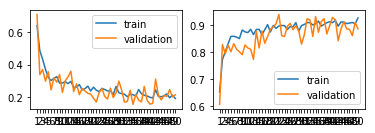

In [8]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

def plot_train_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch_labels = range(1, EPOCHS + 1)
    print (epoch_labels)
    
    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.set_xticks(epoch_labels)
    ax.plot(epoch_labels, train_loss, label='train')
    ax.plot(epoch_labels, val_loss, label='validation')
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    ax.legend()
    
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    bx = fig.add_subplot(222)
    bx.set_xticks(epoch_labels)
    bx.plot(epoch_labels, train_acc, label='train')
    bx.plot(epoch_labels, val_acc, label='validation')
    bx.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    bx.legend()
    
    plt.show()
    
plot_train_history(train_history)

In [9]:
# save model for later use
model.save('model.hdf5')

In [10]:
# load model later on to use it
#TRAINED_WEIGHTS_FILENAME = os.path.join(os.getcwd(), 'weights.09-0.23.hdf5')
#model = load_model(TRAINED_WEIGHTS_FILENAME)

In [11]:
res = model.evaluate_generator(test_generator)
print(model.metrics_names, ':',res)

predictions = model.predict_generator(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

['loss', 'acc'] : [0.2164393076142534, 0.88998035492269367]
             precision    recall  f1-score   support

      chair       0.78      0.67      0.72       408
      couch       0.14      0.22      0.17       101

avg / total       0.65      0.58      0.61       509



In [12]:
new_test_path = os.path.join(os.getcwd(),'new_test')
new_pictures = os.listdir(new_test_path)
new_prediction = []
def prep_data(image):  
    X = np.squeeze(image, axis=0)
    #X = np.expand_dims(image, axis=3)  # add a color channel to each image
    X = X.astype(np.float32)
        
    X = preprocess_input(X)
    img = array_to_img(X)
    return np.expand_dims(img, axis=0)
    
for i in range(len(new_pictures)): # for each file in the new test data, do prediction and save results to a list
    img = load_img(os.path.join(new_test_path, new_pictures[i]), target_size = (IMG_HEIGHT, IMG_WIDTH,))
    prediction = model.predict(prep_data(img))
    new_prediction.append(np.argmax(prediction))

In [14]:
import pandas as pd
result = pd.DataFrame(data={'ID':new_pictures, 'class':new_prediction})
result.to_csv('result_bigData.csv')